## O que tem de diferente entre esse arquivo e o outro é a quantidade de camadas sobre o treinamento, no caso do treinamento com a rede completa, quanto menos camadas, a acurácia e a perda é melhor. Ja no modelo de camada a camada dimunuir causa prejuiso mas aumentar não causa um ganho; entretanto foi adicionado o uso de ImageDataGenerator para aumento de dados, que inclui rotações, deslocamentos e zoom; a taxa de dropout foi aumentada para 0.3; o tamanho do lote foi reduzido para 64; e foi incluído o callback ReduceLROnPlateau, além de ajustar os dados de entrada para quatro dimensões. O critério de parada é que, se a perda de validação não melhorar por 15 épocas consecutivas, o treinamento é interrompido ou se atingir o numero maximo de epocas que é mil, tudo isso é impresso nos dois arquivos.

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [31]:
def carregar_e_preparar_dados():
    (x_treino, y_treino), (x_teste, y_teste) = tf.keras.datasets.mnist.load_data()
    x_treino, x_teste = x_treino / 255.0, x_teste / 255.0
    y_treino = tf.keras.utils.to_categorical(y_treino, 10)
    y_teste = tf.keras.utils.to_categorical(y_teste, 10)
    return (x_treino, y_treino), (x_teste, y_teste)

(x_treino, y_treino), (x_teste, y_teste) = carregar_e_preparar_dados()

In [32]:
def plotar_historico(historico, titulo):
    plt.plot(historico.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title(titulo)
    plt.legend()
    plt.show()

    plt.plot(historico.history['loss'], label='Perda de Treinamento')
    plt.plot(historico.history['val_loss'], label='Perda de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.title(titulo)
    plt.legend()
    plt.show()

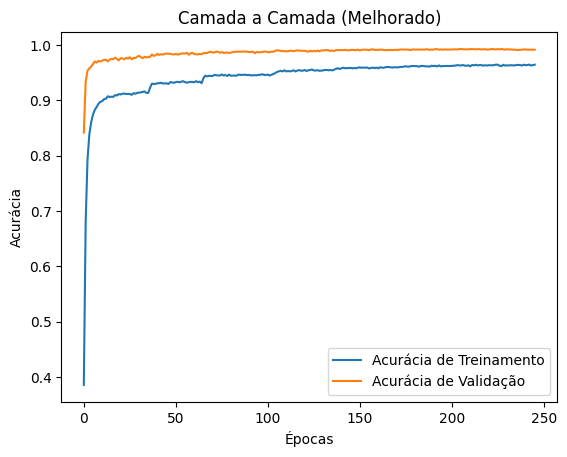

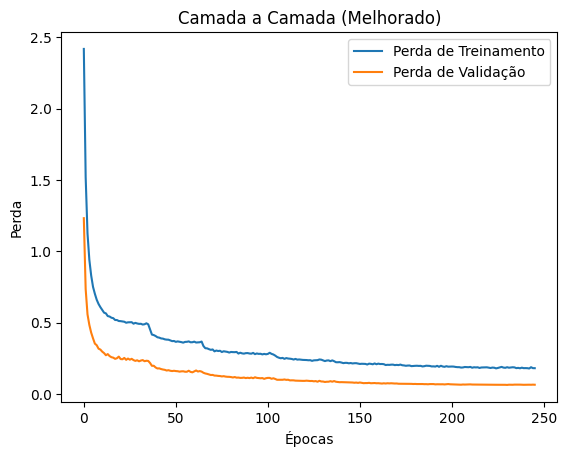

Camada a Camada (Melhorado) - Perda: 0.06406650692224503, Acurácia: 0.9927999973297119, Épocas: 246


In [33]:
def treinar_camada_a_camada(x_treino, y_treino, x_teste, y_teste):
    modelo = Sequential()
    modelo.add(tf.keras.layers.Input(shape=(28, 28)))
    modelo.add(Flatten())

    # Ajustando a arquitetura para 5 camadas intermediárias
    unidades_por_camada = [256, 128, 64, 32, 16]
    for unidades in unidades_por_camada:
        modelo.add(Dense(unidades, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        modelo.add(BatchNormalization())
        modelo.add(Dropout(0.3))

    # Adicionando a camada de saída
    modelo.add(Dense(10, activation='softmax'))

    # Compilando o modelo
    modelo.compile(optimizer=Adam(learning_rate=0.0005), loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Expande a dimensão dos dados de entrada para incluir o canal de cor
    x_treino_expanded = np.expand_dims(x_treino, axis=-1)
    x_teste_expanded = np.expand_dims(x_teste, axis=-1)

    # Configuração do aumento de dados
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1
    )

    # Ajustar o gerador de dados ao conjunto de treinamento
    datagen.fit(x_treino_expanded)

    # Callbacks para treinamento
    parada_precoce = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reducao_taxa_aprendizado = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

    # Treinando o modelo usando o gerador de dados
    historico = modelo.fit(datagen.flow(x_treino_expanded, y_treino, batch_size=64),
                           epochs=1000,
                           validation_data=(x_teste_expanded, y_teste),
                           callbacks=[parada_precoce, reducao_taxa_aprendizado],
                           verbose=0)

    # Avaliando o modelo
    perda_teste, acuracia_teste = modelo.evaluate(x_teste_expanded, y_teste, verbose=0)
    plotar_historico(historico, "Camada a Camada (Melhorado)")
    return modelo, perda_teste, acuracia_teste, len(historico.history['loss'])

# Supondo que x_treino, y_treino, x_teste, y_teste já estejam carregados e pré-processados
modelo_camada_a_camada, perda_camada_a_camada, acuracia_camada_a_camada, epocas_camada_a_camada = treinar_camada_a_camada(x_treino, y_treino, x_teste, y_teste)
print(f'Camada a Camada (Melhorado) - Perda: {perda_camada_a_camada}, Acurácia: {acuracia_camada_a_camada}, Épocas: {epocas_camada_a_camada}')

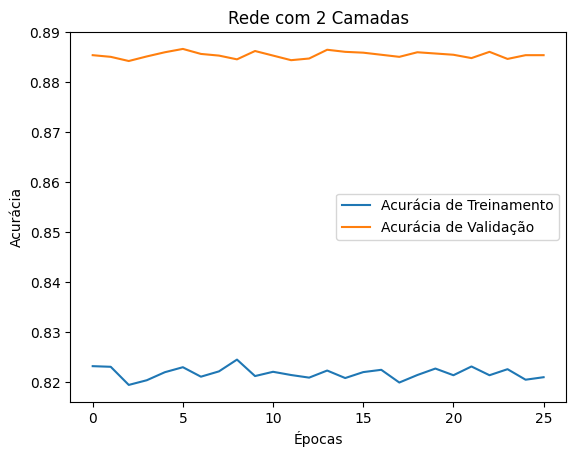

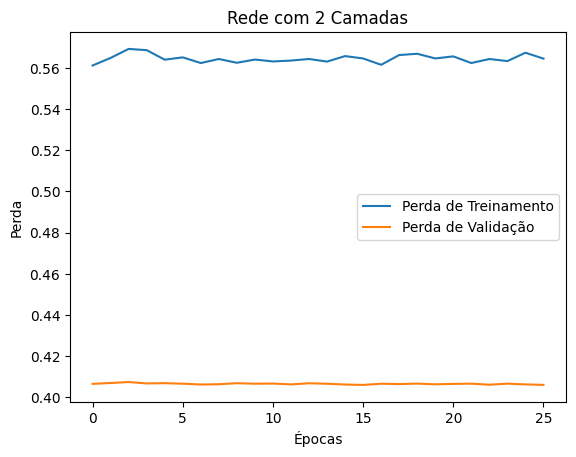

Rede com 2 Camadas - Perda: 0.4124870002269745, Acurácia: 0.8780999779701233, Épocas: 200


In [34]:
# Função para treinar um modelo com 2 camadas intermediárias
def treina_completa_2camadas(x_treino, y_treino, x_teste, y_teste):
    modelo = Sequential()
    modelo.add(tf.keras.layers.Input(shape=(28, 28)))  
    modelo.add(Flatten())
    
    unidades_por_camada = [128]  # Apenas 2 camadas sendo uma intermediária 
    for unidades in unidades_por_camada:
        modelo.add(Dense(unidades, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        modelo.add(BatchNormalization())
        modelo.add(Dropout(0.2))
    
    # Adicionando a camada de saída
    modelo.add(Dense(10, activation='softmax'))
    
    # Congelar todas as camadas exceto a última durante o treinamento inicial
    for camada in modelo.layers[:-1]:
        camada.trainable = False

    # Compilando o modelo
    modelo.compile(optimizer=Adam(learning_rate=0.0005), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    parada_precoce = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    historico = modelo.fit(x_treino, y_treino, epochs=1000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[parada_precoce])
    
    # Descongelar todas as camadas e treinar novamente
    for camada in modelo.layers:
        camada.trainable = True
    historico_final = modelo.fit(x_treino, y_treino, epochs=1000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[parada_precoce])
    
    # Avaliando o modelo no conjunto de teste
    perda_teste, acuracia_teste = modelo.evaluate(x_teste, y_teste, verbose=0)
    plotar_historico(historico_final, "Rede com 2 Camadas")
    return modelo, perda_teste, acuracia_teste, len(historico.history['loss']) + len(historico_final.history['loss'])

# Executando o treinamento do modelo com 2 camadas intermediárias
modelo_duas_camadas, perda_duas_camadas, acuracia_duas_camadas, epocas_duas_camadas = treina_completa_2camadas(x_treino, y_treino, x_teste, y_teste)
print(f'Rede com 2 Camadas - Perda: {perda_duas_camadas}, Acurácia: {acuracia_duas_camadas}, Épocas: {epocas_duas_camadas}')

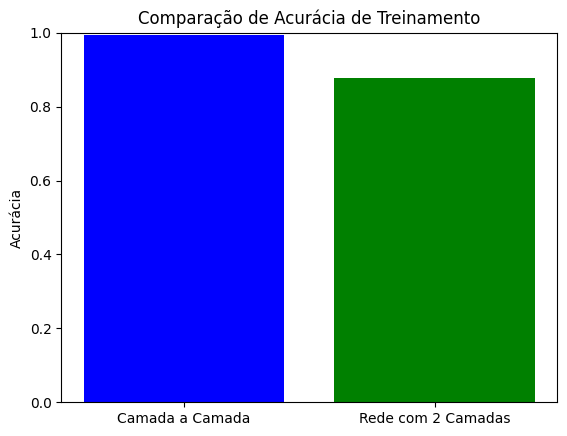

In [36]:
# Visualização dos Resultados
def plotar_resultados_treinamento(acuracia_camada_a_camada, acuracia_duas_camadas):
    etiquetas = ['Camada a Camada', 'Rede com 2 Camadas']
    acuracias = [acuracia_camada_a_camada, acuracia_duas_camadas]
    plt.bar(etiquetas, acuracias, color=['blue', 'green'])
    plt.ylabel('Acurácia')
    plt.title('Comparação de Acurácia de Treinamento')
    plt.ylim(0, 1)
    plt.show()

# Chamada da função com as três acurácias
plotar_resultados_treinamento(acuracia_camada_a_camada, acuracia_duas_camadas)